In [ ]:
#un canale

In [2]:
from NewLibraryENGcopia import *

#POPULATION 1 (HEALTHY):
name_data_st = '2019-01-23T16-06-32Pop1 healthy cortical stimulation modifiedname.h5'
name_data_BL = '2019-01-23T11-19-05PoP1 healthy cortical .h5'
name_data_24 = '2019-01-24T16-00-33Pop1 24hour after.h5'
complete_string='/Users/Gaia_1/Desktop/allh5filestutto/'+name_data_BL
#complete_string='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_stimulation/'+name_data_st
#complete_string='/Users/Gaia_1/Desktop/allh5files/healthy/healthy 24hrs later/'+name_data_24

In [2]:
def this_poiproc(neurons,target,stim):
    from scipy.stats import ks_2samp
    dataframe = pd.DataFrame()
    #counter_net=1
    counter=0
    #for net in list_dir_ok:
    #print(counter_net,') ',net)
    #counter_net+=1
    list_neurons = neurons #np.genfromtxt(net, delimiter=',')
    counter=0
    print('Original number of neurons: ',len(list_neurons))
    for neuron in tqdm(list_neurons):
        neuron=neuron[neuron>0*10000]
        neuron=neuron[neuron<200*10000]
        print('  Neuron with ',neuron.shape[0],'spikes')
        if neuron.shape[0]>1000:
            
            counter+=1
        else:
            print('    Excluded neuron with n spikes = ',neuron.shape[0])
            continue
        
        ISI_healthy = np.diff(neuron)/10000
        map_estimate = Bayesian_mixture_model(ISI_healthy)
        map_estimate['Target']=int(target)
        map_estimate['Stimulation']=int(stim)
        df = pd.DataFrame.from_dict(map_estimate,orient='index')
        dataframe = pd.concat([dataframe,df],axis = 1)
    print('Final number of neurons: ',counter)
    print('Target = ',target)
    return dataframe



    #ks_2samp(lista_samples,ISI_healthy,mode = 'asymp')


In [6]:
def this_spike_sorting(name_data,complete_string,threshold,clustering,coeff,c1):
    #file reading:
    data = h5py.File(complete_string,'r')
    data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
    info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
    info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
    labels = info_table['Label']
    readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
    fs = 10000 #Sampling Frequency
    print('data shape: ',readings.shape)
    prova=readings.drop([b'Ref'],axis=1)
    #prova=prova.iloc[inizio:fine, :10]
    prova=prova.iloc[:, :10]
    ref=readings[b'Ref']
    #ref=ref[inizio:fine]
    #filtering:
    prova_rows = range(prova.shape[0])
    filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
    lowcut = 300
    highcut = 3000
    fs=10000
    order=8
    b,a=butter_bandpass(lowcut,highcut,fs,order=order)
    filt_ref=filtfilt(b,a,ref)
    for x in tqdm(range(prova.shape[1])):
        filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
    for electrode in prova.columns:
        filt_prova[electrode] = filt_prova[electrode] - filt_ref
    prova=filt_prova
    #detection:
    if threshold==0:
        threshold=[]
        for i,electrode in tqdm(enumerate(prova.columns)):
            threshold.append(coeff*(scipy.stats.median_abs_deviation(prova[electrode].values,scale='normal')))            
    all_ind=[]
    for i,electrode in tqdm(enumerate(prova.columns)):
        channel=prova[electrode]
        #thresh=threshold[i]
        ind=this_windowed_find_all_spikes(channel,coeff)
        all_ind.append(ind)
    #spike extraction:
    cut_outs=[]
    all_new=[]
    for i,electrode in enumerate(tqdm(prova.columns)):
        ind=all_ind[i]
        channel=prova[electrode]
        cut_outs1,all_new1=cut_all(ind,channel,c1)
        cut_outs.append(cut_outs1)
        all_new.append(all_new1)    
    # Clustering:
    final_data=[]
    if clustering=='kmeans':
            for channel in (tqdm(range(len(cut_outs)))):
                #channel_clusters1=comparative_clus(cut_outs[channel],all_new[channel],prova.iloc[:,channel])
                channel_clusters1=clus(cut_outs[channel],all_new[channel],prova.iloc[:,channel])
                final_data.append(channel_clusters1)
    elif clustering=='dbscan':
            for channel in (tqdm(range(len(cut_outs)))):
                eps=int(scipy.stats.median_abs_deviation(prova.iloc[:,channel])/2)
                channel_clusters1=dbscan_clustering(cut_outs[channel],all_new[channel],prova.iloc[:,channel],eps)
                final_data.append(channel_clusters1)
    neurons=[]
    for channel in final_data:
        for neuron in channel:
            neurons.append(neuron)
    print(len(neurons),' neurons detected and sorted')
    adj_neur=[]
    counter = 0
    max_len=0
    for neuron in neurons:
        print('counter: ',counter,neuron.shape[0])
        if neuron.shape[0]>max_len:
            max_len=neuron.shape[0]
        counter+=1
    for neuron in neurons:
        if neuron.shape[0]<max_len and neuron.shape[0]>=1000:
            diff = max_len-neuron.shape[0]
            adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))
    save_data = 'After'+name_data+'.txt'
    np.savetxt("/Users/Gaia_1/Desktop/tesi/Data after SS prova/%s.txt" % save_data,adj_neur, delimiter=', ', fmt='%12.8f')
    print(save_data)
    return neurons


In [31]:
def this_windowed_spike_detection(data,abso):
    spike_length=30 #3ms
    window_length=10000 #1 sec
    abs_data=abs(data)
    i=0
    ind=[]
    while i < len(data)+window_length:
        abs_window=abs_data[i:i+window_length]
        window=data[i:i+window_length]
        coeff=4
        if abso==0:
            thresh=coeff*(scipy.stats.median_abs_deviation(window,scale='normal'))
        else:
            thresh=coeff*(scipy.stats.median_abs_deviation(abs_window,scale='normal'))
        ind1, peaks =find_peaks(abs_window, height=thresh,distance=spike_length)
        last=i
        if len(ind1):
            last=i+ind1[-1]
        ind.extend([index + i for index in ind1])
        i=last+spike_length
        
        #PLOT:
        plt.plot(window)
        plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
        plt.axhline(y=-threshold, color='r', linestyle='--', label='Threshold')
        plt.scatter(ind1, [window[i] for i in ind1], c='red', marker='o', label='Local Maxima')
        plt.show()
        plt.pause(0.5)  # Adjust the duration as needed
        
        # Clear the plot for the next iteration
        plt.clf()

    firing_rate=len(ind)*10000/len(data)
    print(len(ind), ' spikes detected;  ', 'firing rate: {:.2f}'.format(firing_rate),'Hz')
    return ind


In [42]:
#def this_spike_detection(data,abso):
data=part
abso=0
spike_length=30 #3ms
window_length=10000 #1 sec
neg_data=-(data)
abs_data=abs(data)
i=0
ind=[]
while i < len(data)-window_length:
    window=data[i:i+window_length]
    neg_window=neg_data[i:i+window_length]
    abs_window=abs_data[i:i+window_length]
    window=data[i:i+window_length]
    coeff=4
    if abso==0:
        thresh=coeff*(scipy.stats.median_abs_deviation(window,scale='normal'))
    else:
        thresh=coeff*(scipy.stats.median_abs_deviation(abs_window,scale='normal'))
    ind1, peaks =find_peaks(neg_window, height=thresh,distance=spike_length)
    del peaks
    last=i
    if len(ind1):
        last=i+ind1[-1]
    ind.extend([index + i for index in ind1])
    i=last+10 #0.01 s

    #PLOT:
    plt.plot(window)
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.axhline(y=-threshold, color='r', linestyle='--', label='Threshold')
    plt.scatter(ind1, [window[i] for i in ind1], c='red', marker='o', label='Local Maxima')
    plt.show()
    plt.pause(0.5)  # Adjust the duration as needed

    # Clear the plot for the next iteration
    plt.clf()
plt.show()
firing_rate=len(ind)*10000/len(data)
print(len(ind), ' spikes detected;  ', 'firing rate: {:.2f}'.format(firing_rate),'Hz')
#return ind


0  spikes detected;   firing rate: 0.00 Hz


135.1581080252923


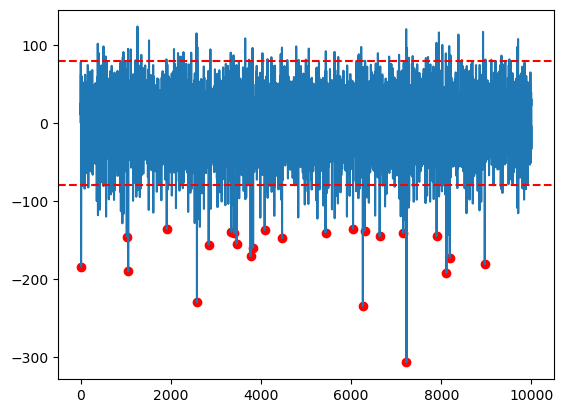

In [51]:
window=data[i:i+window_length]
neg_window=neg_data[i:i+window_length]
thresh=4*(scipy.stats.median_abs_deviation(window,scale='normal'))
print(thresh)
ind1, peaks =find_peaks(neg_window, height=thresh,distance=spike_length)
plt.plot(window)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(ind1, [window[i] for i in ind1], c='red', marker='o', label='Local Maxima')
plt.show()


79.88123599759551


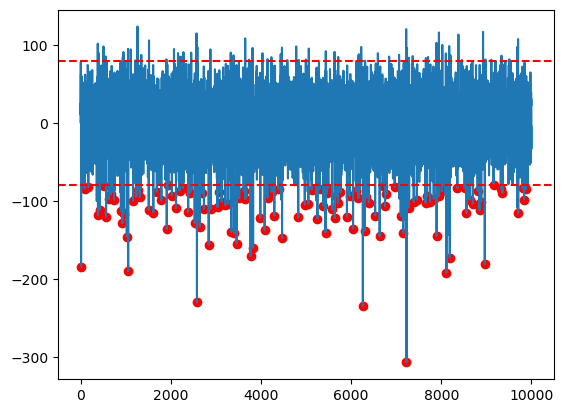

In [52]:
window=data[i:i+window_length]
abs_window=abs_data[i:i+window_length]
thresh=4*(scipy.stats.median_abs_deviation(abs_window,scale='normal'))
print(thresh)
neg_window=neg_data[i:i+window_length]
ind1, peaks =find_peaks(neg_window, height=thresh,distance=spike_length)
plt.plot(window)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(ind1, [window[i] for i in ind1], c='red', marker='o', label='Local Maxima')
plt.show()


In [ ]:
ind0=this_windowed_spike_detection(part,0)

In [ ]:
ind1=this_windowed_spike_detection(part,1)

In [40]:
ind2=this_spike_detection(part,0)

0  spikes detected;   firing rate: 0.00 Hz


In [41]:
ind3=this_spike_detection(part,1)

0  spikes detected;   firing rate: 0.00 Hz


In [10]:
neurons=this_spike_sorting(name_data_BL,complete_string, 0,'kmeans',4,2)

data shape:  (4222000, 60)


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

IndexError: index -1 is out of bounds for axis 0 with size 0

In [3]:
data = h5py.File(complete_string,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(4222000, 60)


In [4]:
inizio=0
len_data=180000 #192 secondi
len_data=len(readings)
prova_multi=readings.iloc[inizio:len_data, :59]
#prova=prova.drop([b'Ref'],axis=1)
prova=prova_multi[b'33']
ref=readings[b'Ref']
ref=ref[inizio:len_data]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

(4222000,) (4222000,)


In [5]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
#r_prova=prova.reshape(-1, 1)
#scaler = StandardScaler()
#s_prova = scaler.fit_transform(r_prova)
#prova=s_prova
#s_prova.shape

(4222000,)

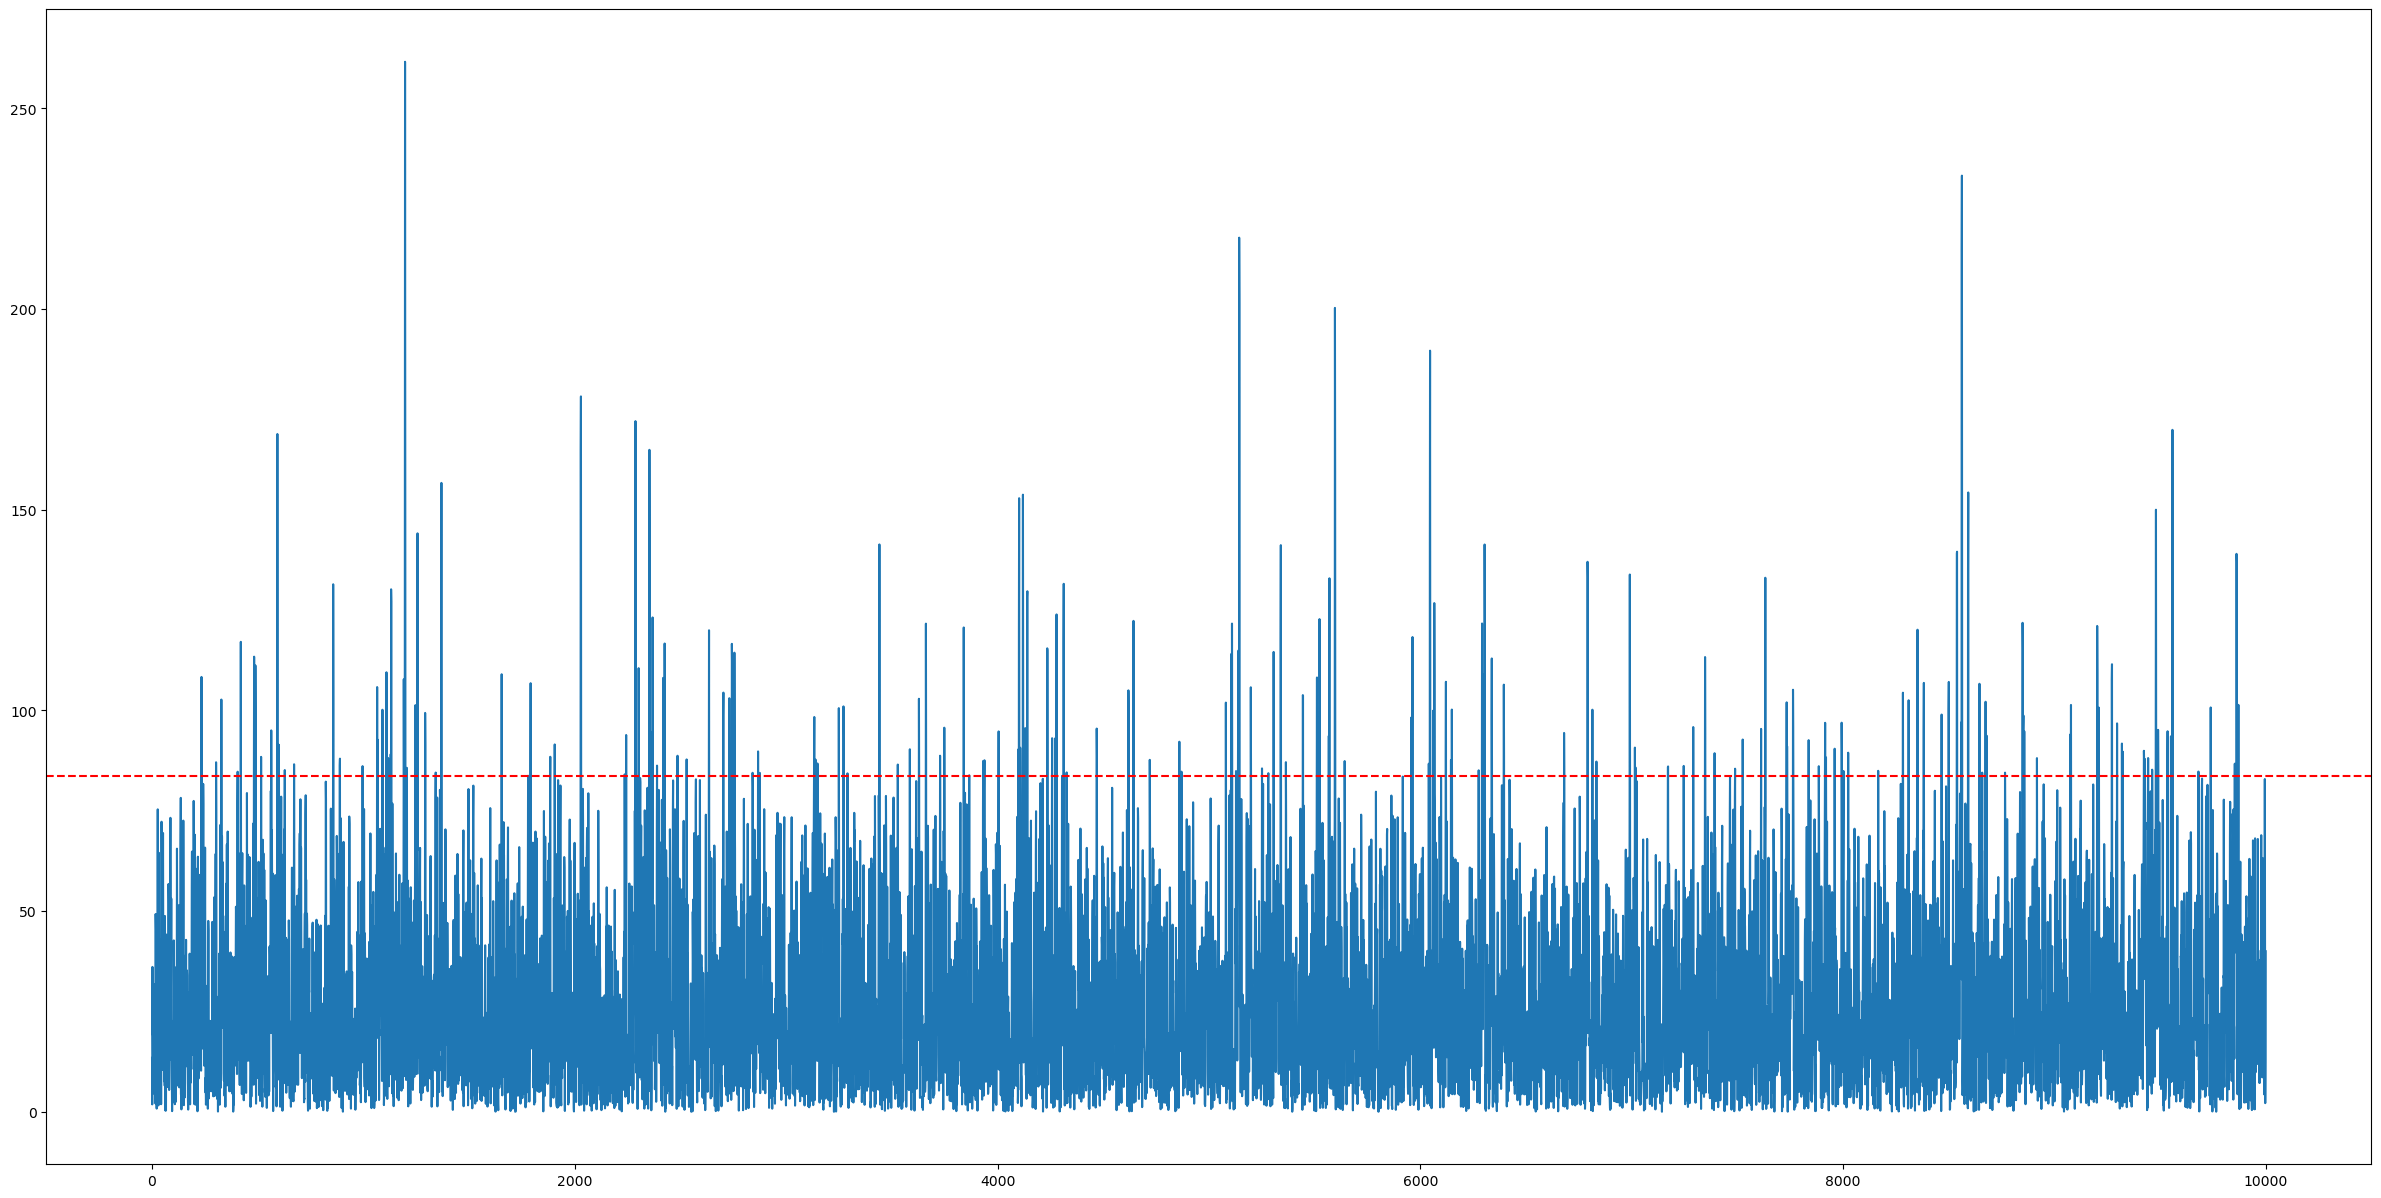

77  spikes detected;   firing rate: 77.00 Hz


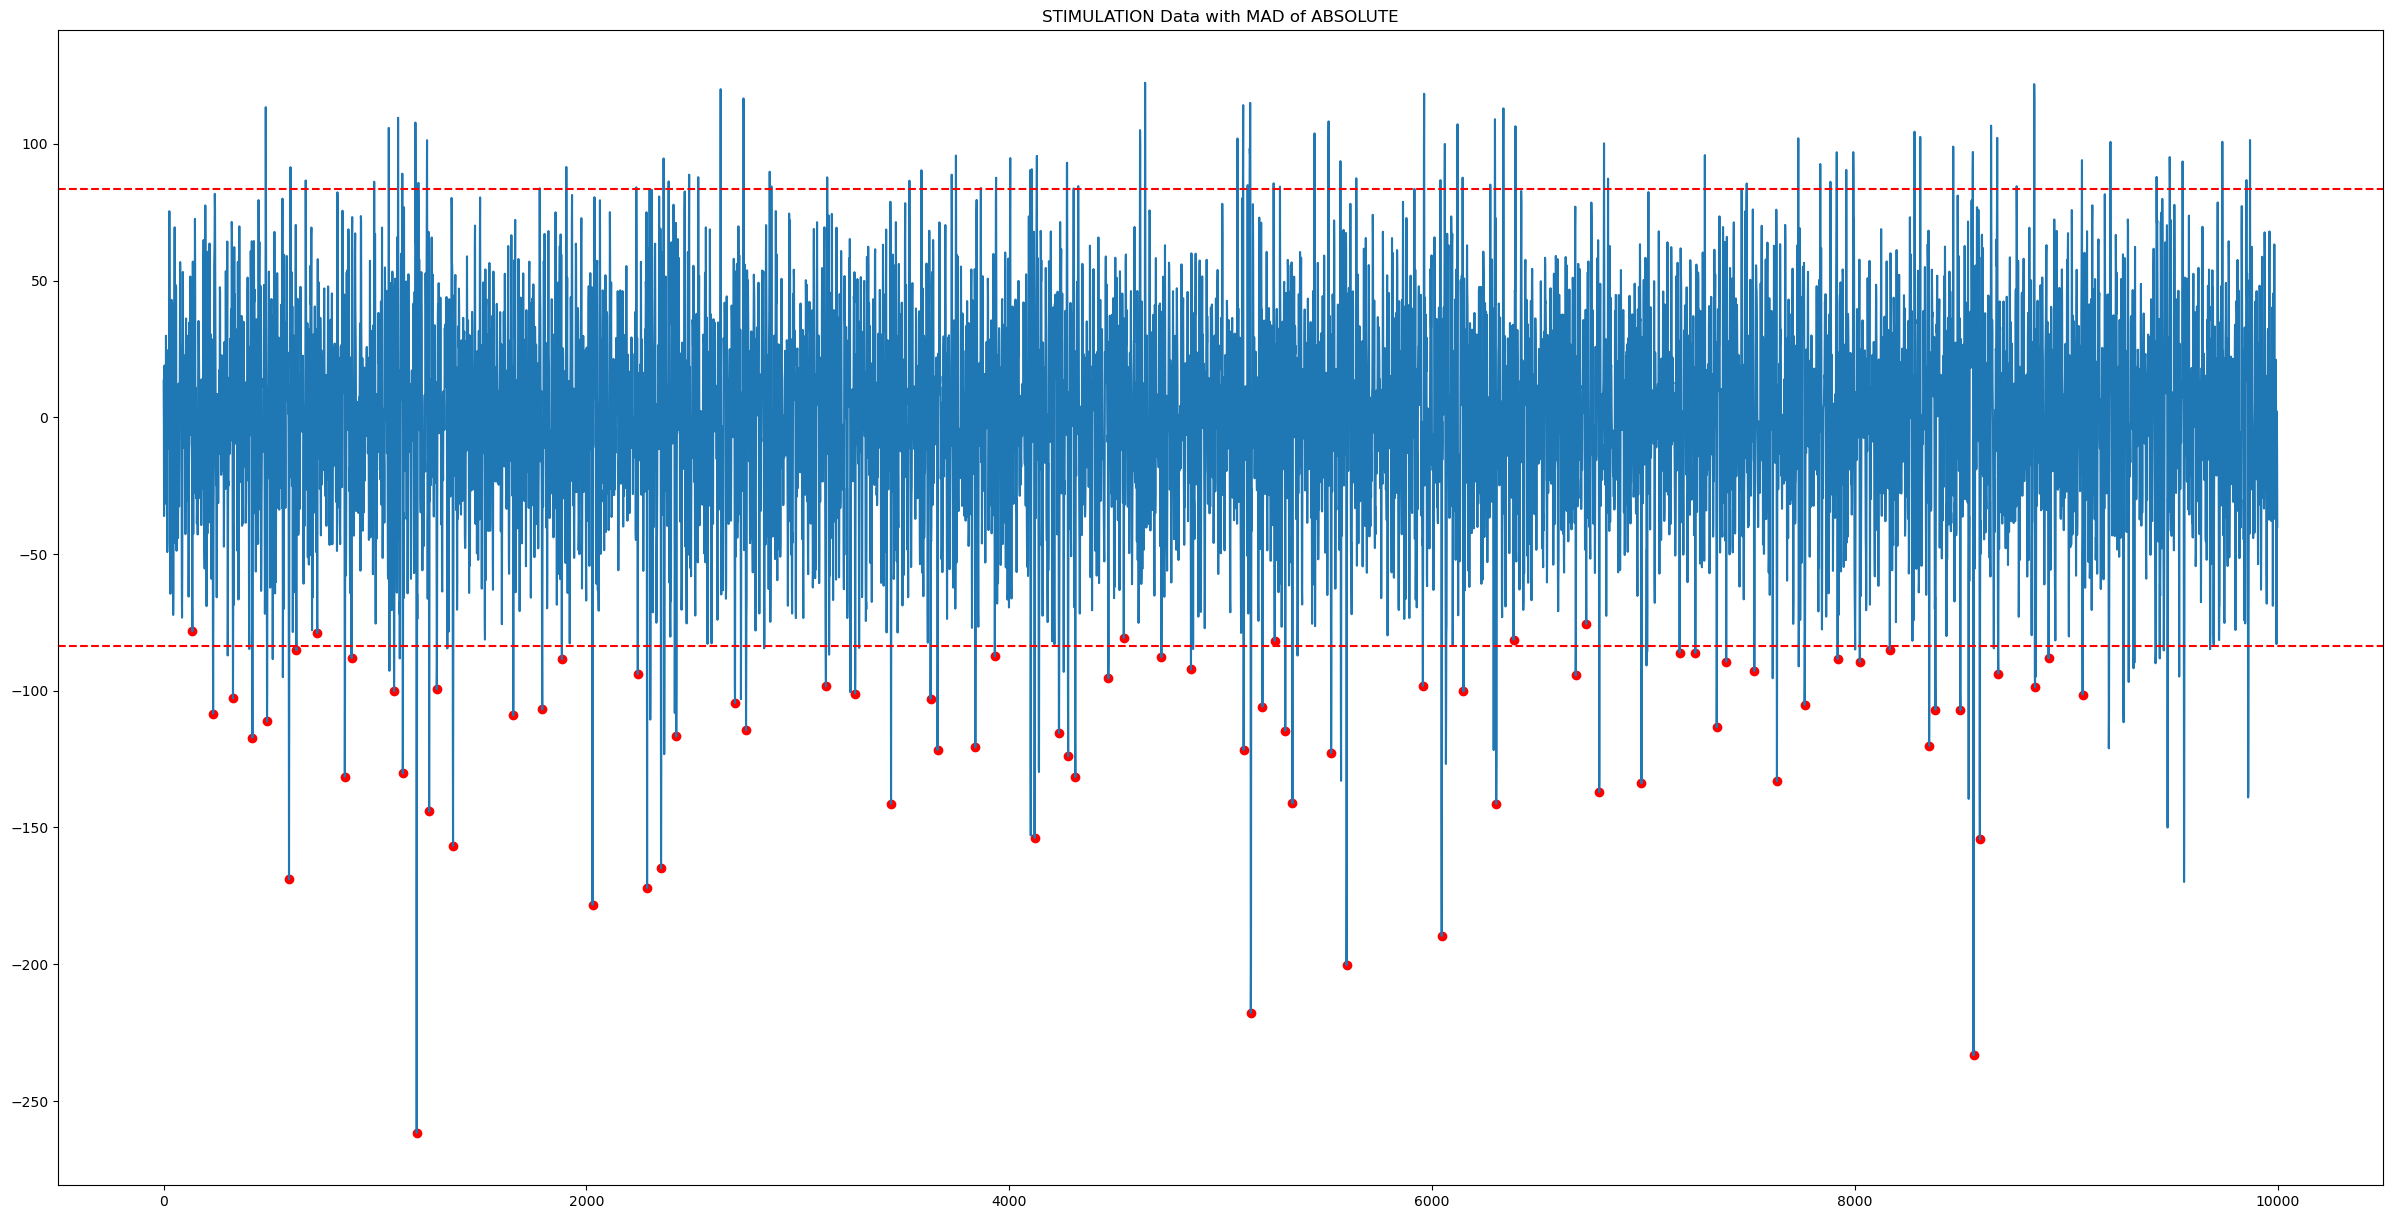

20  spikes detected;   firing rate: 20.00 Hz


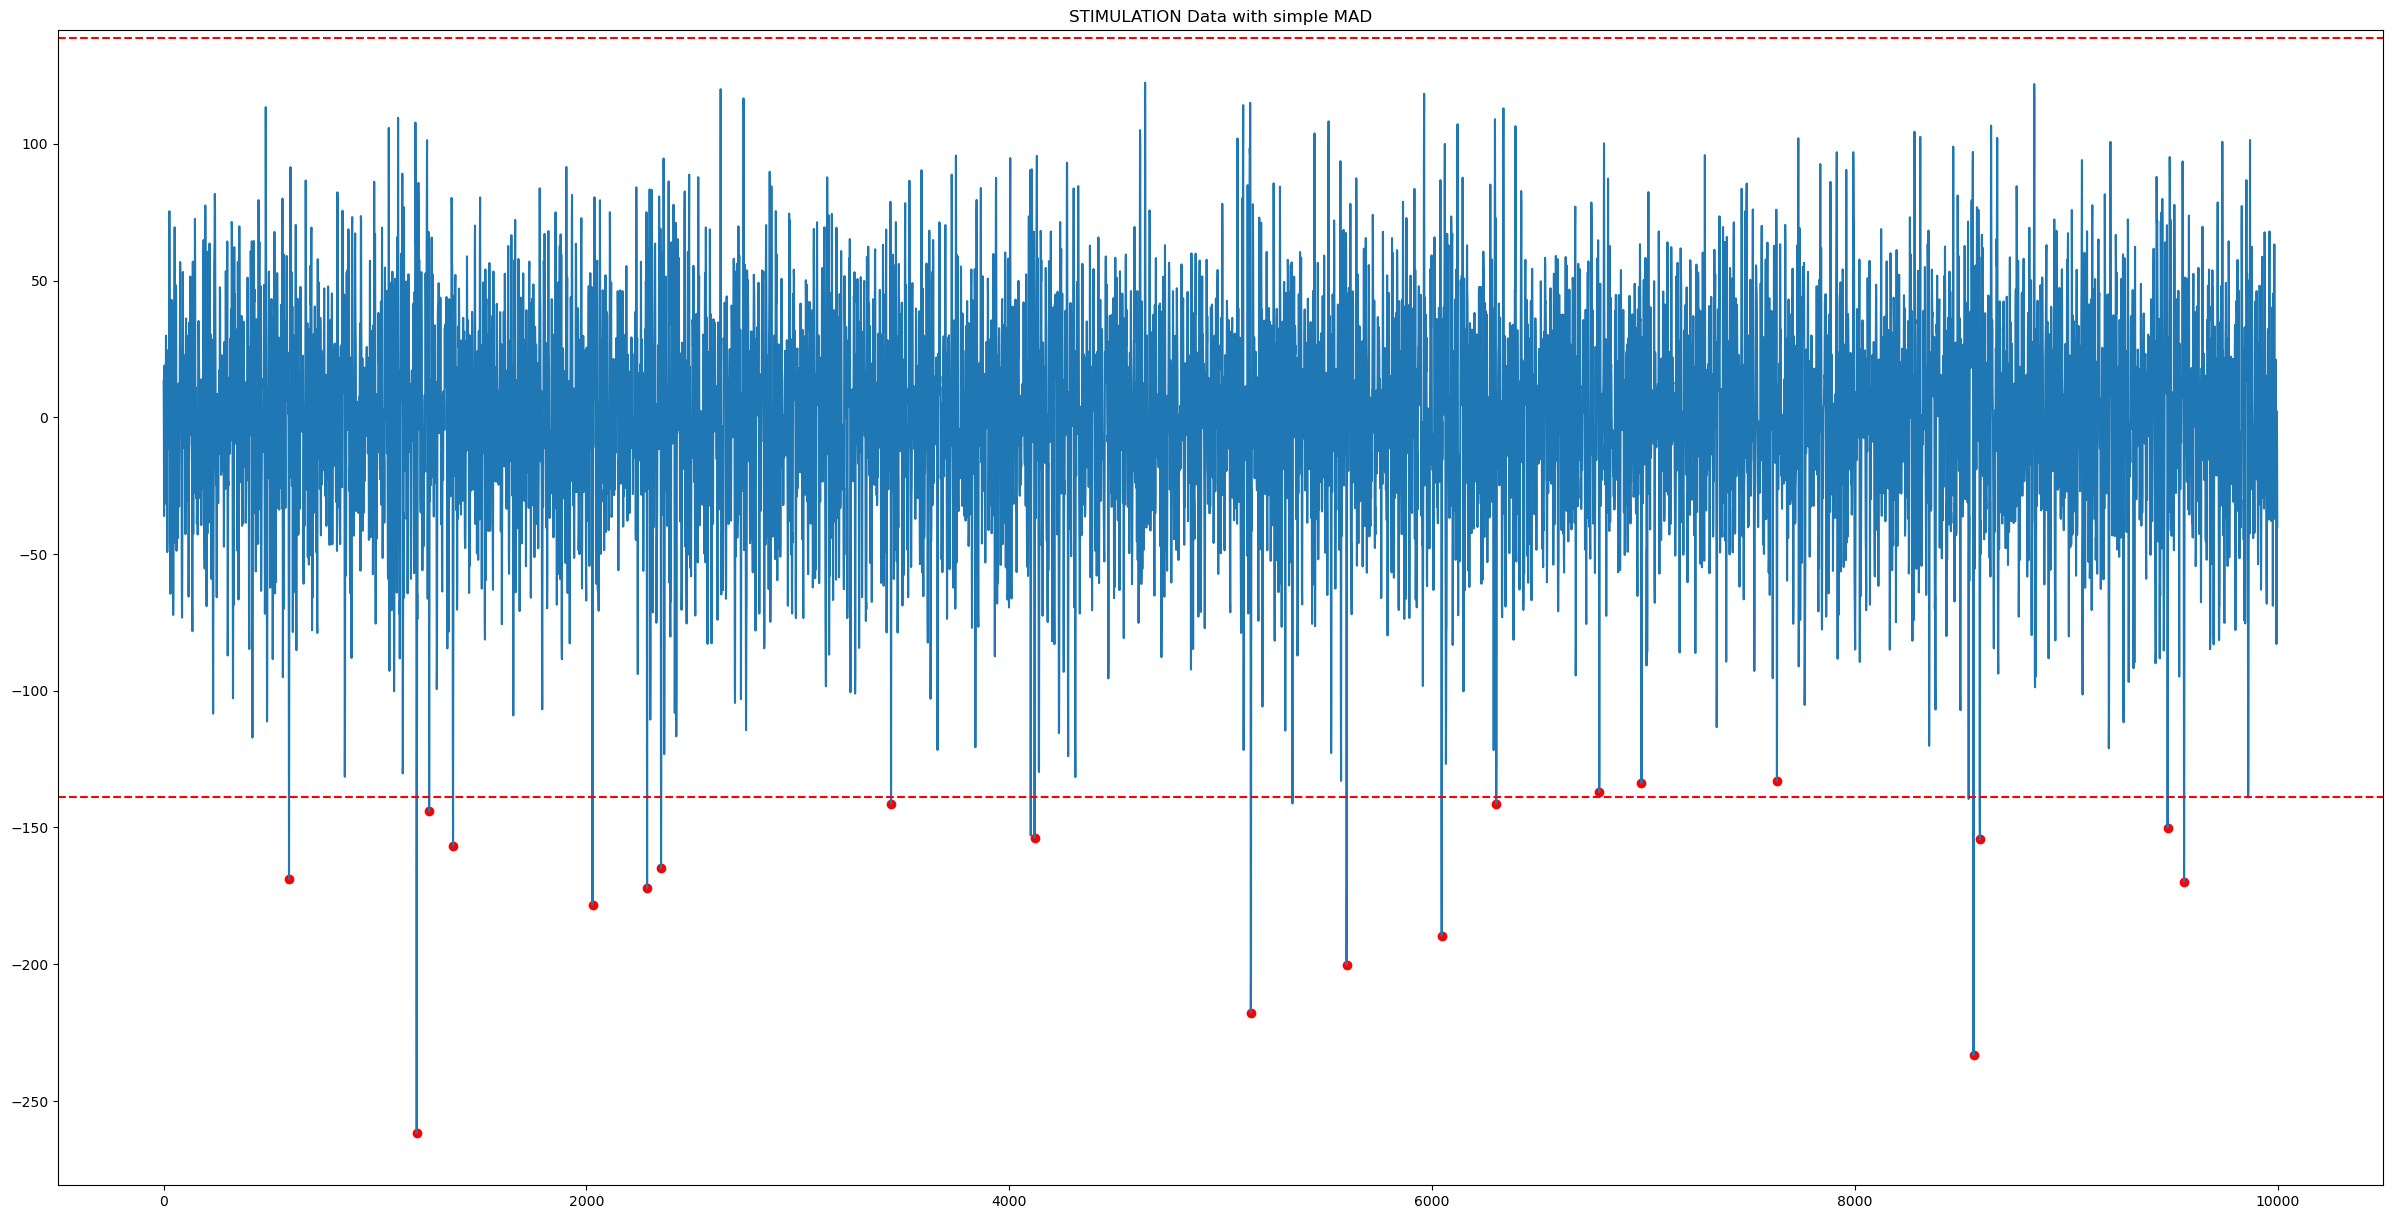

In [7]:
from NewLibraryENGcopia import *
part=prova[30000:40000]
abs_part=abs(part)
threshold=4*(scipy.stats.median_abs_deviation(abs_part,scale='normal'))
plt.figure(figsize=(30, 15))
plt.plot(abs_part)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.show()
inds=spike_detection(part,1,4)
plt.figure(figsize=(30, 15))
plt.title('STIMULATION Data with MAD of ABSOLUTE')
plt.plot(part)
plt.scatter(inds, [part[i] for i in inds], c='red', marker='o', label='Local Maxima')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='r', linestyle='--', label='Threshold')
#plt.savefig('exampleofMADofABSofSTIMULATION.jpg')
plt.show()
threshold=4*(scipy.stats.median_abs_deviation(part,scale='normal'))
inds=spike_detection(part,0,4)
plt.figure(figsize=(30, 15))
plt.title('STIMULATION Data with simple MAD')
plt.plot(part)
plt.scatter(inds, [part[i] for i in inds], c='red', marker='o', label='Local Maxima')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='r', linestyle='--', label='Threshold')
#plt.savefig('exampleofsimpleMADofSTIMULATION.jpg')
plt.show()


In [62]:
inds1=this_windowed_spike_detection(part,0)

24  spikes detected;   firing rate: 24.00 Hz


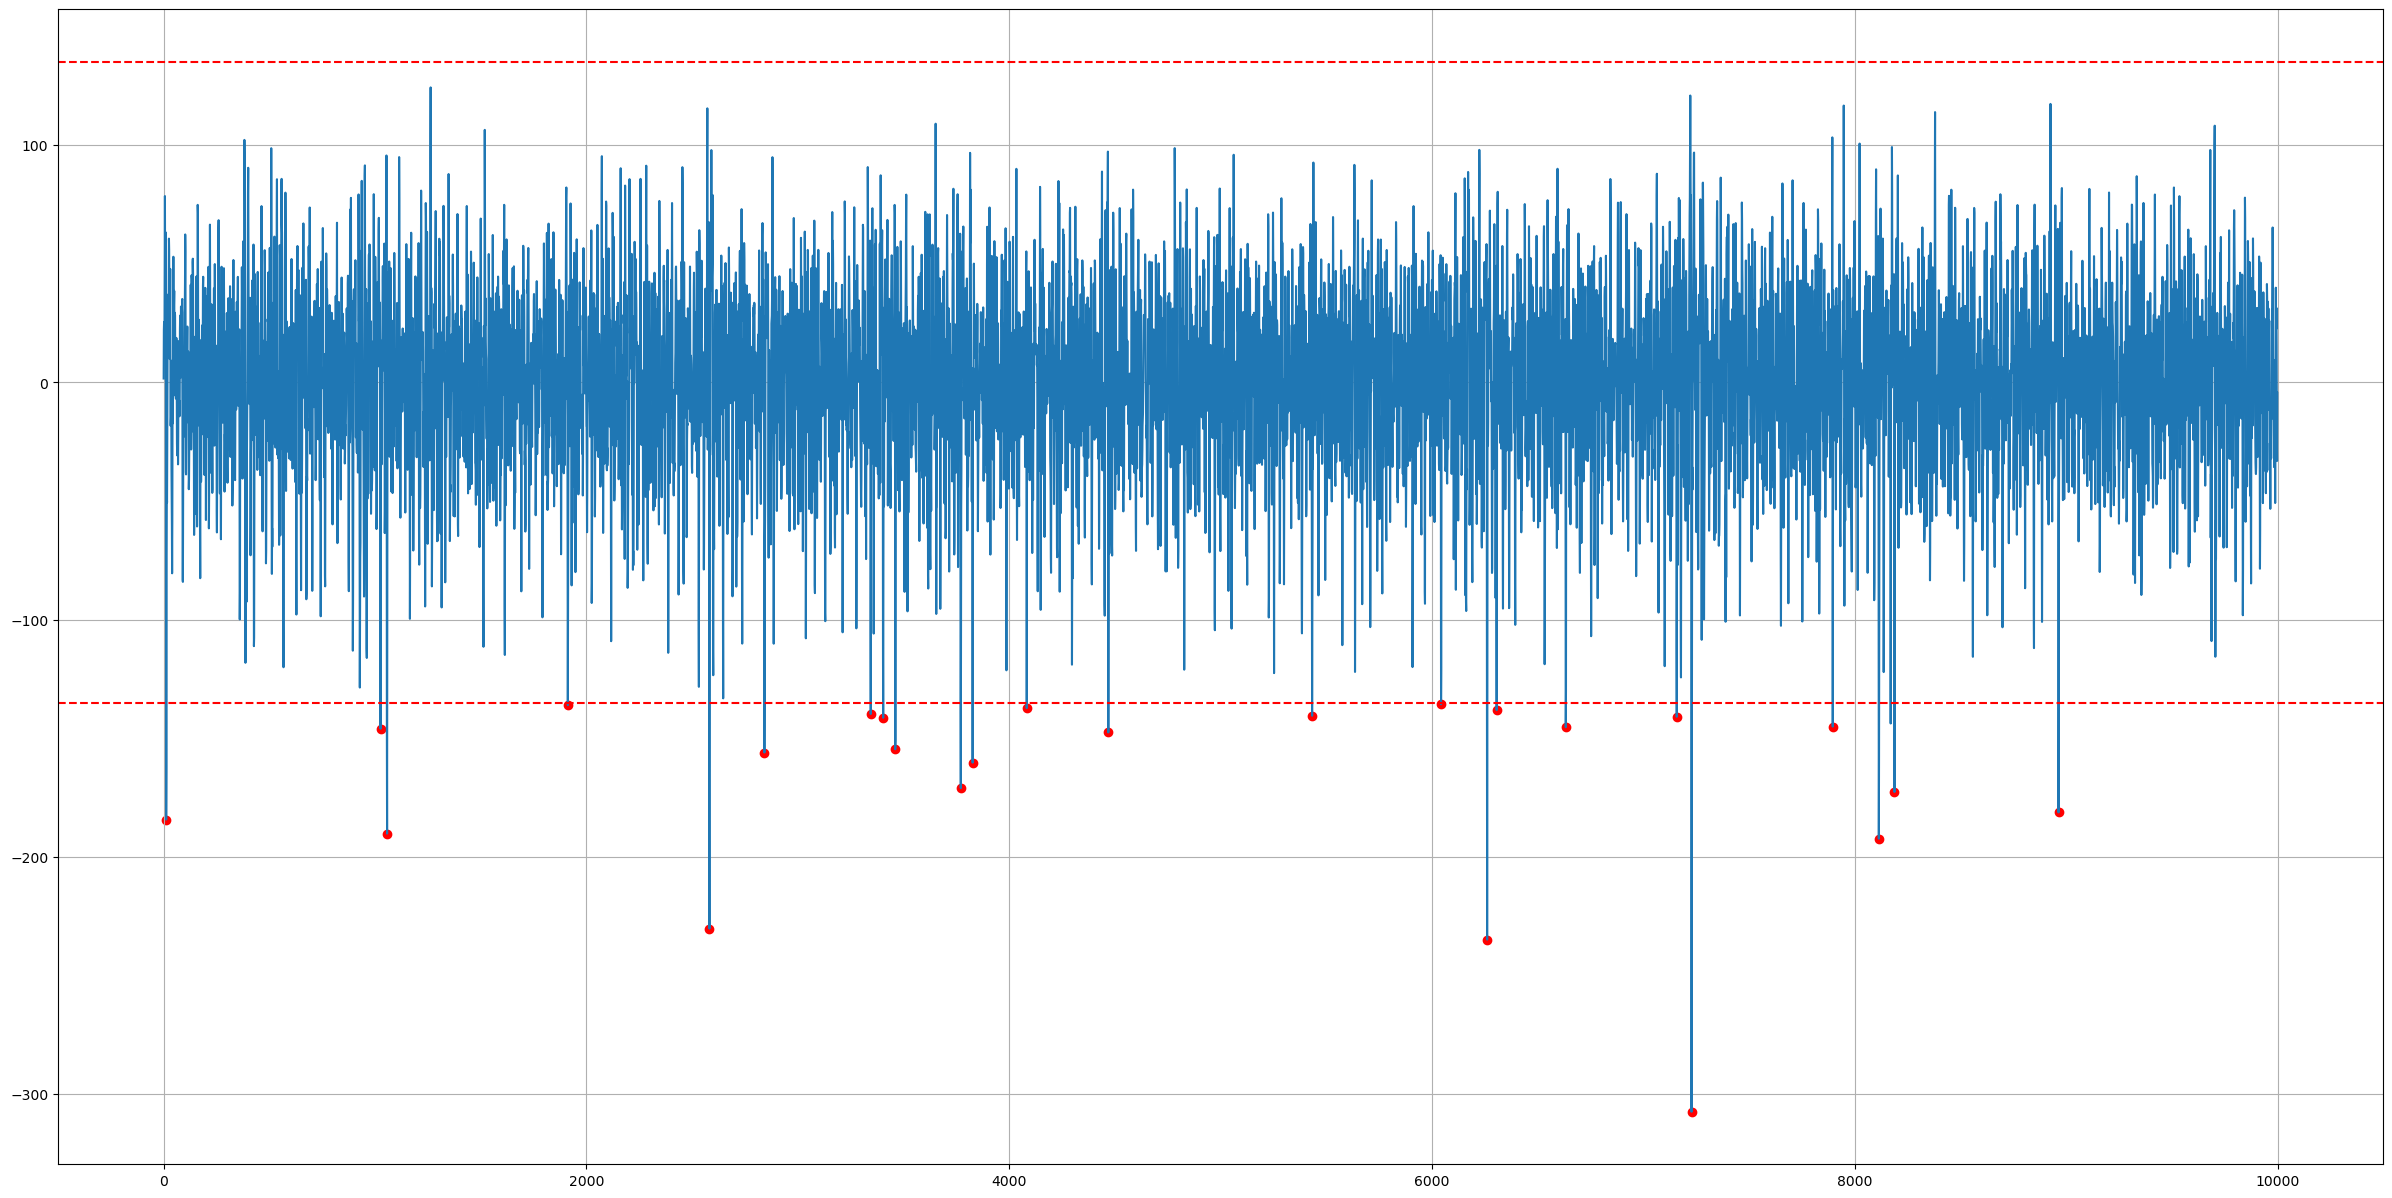

In [63]:
threshold=4*(scipy.stats.median_abs_deviation(part,scale='normal'))
plt.figure(figsize=(30, 15))
plt.plot(part)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(inds1, [part[i] for i in inds1], c='red', marker='o', label='Local Maxima')
plt.grid(True)
#plt.axis([0,3000,-5,5])
plt.savefig('exampleofsimpleMAD.jpg')
plt.show()

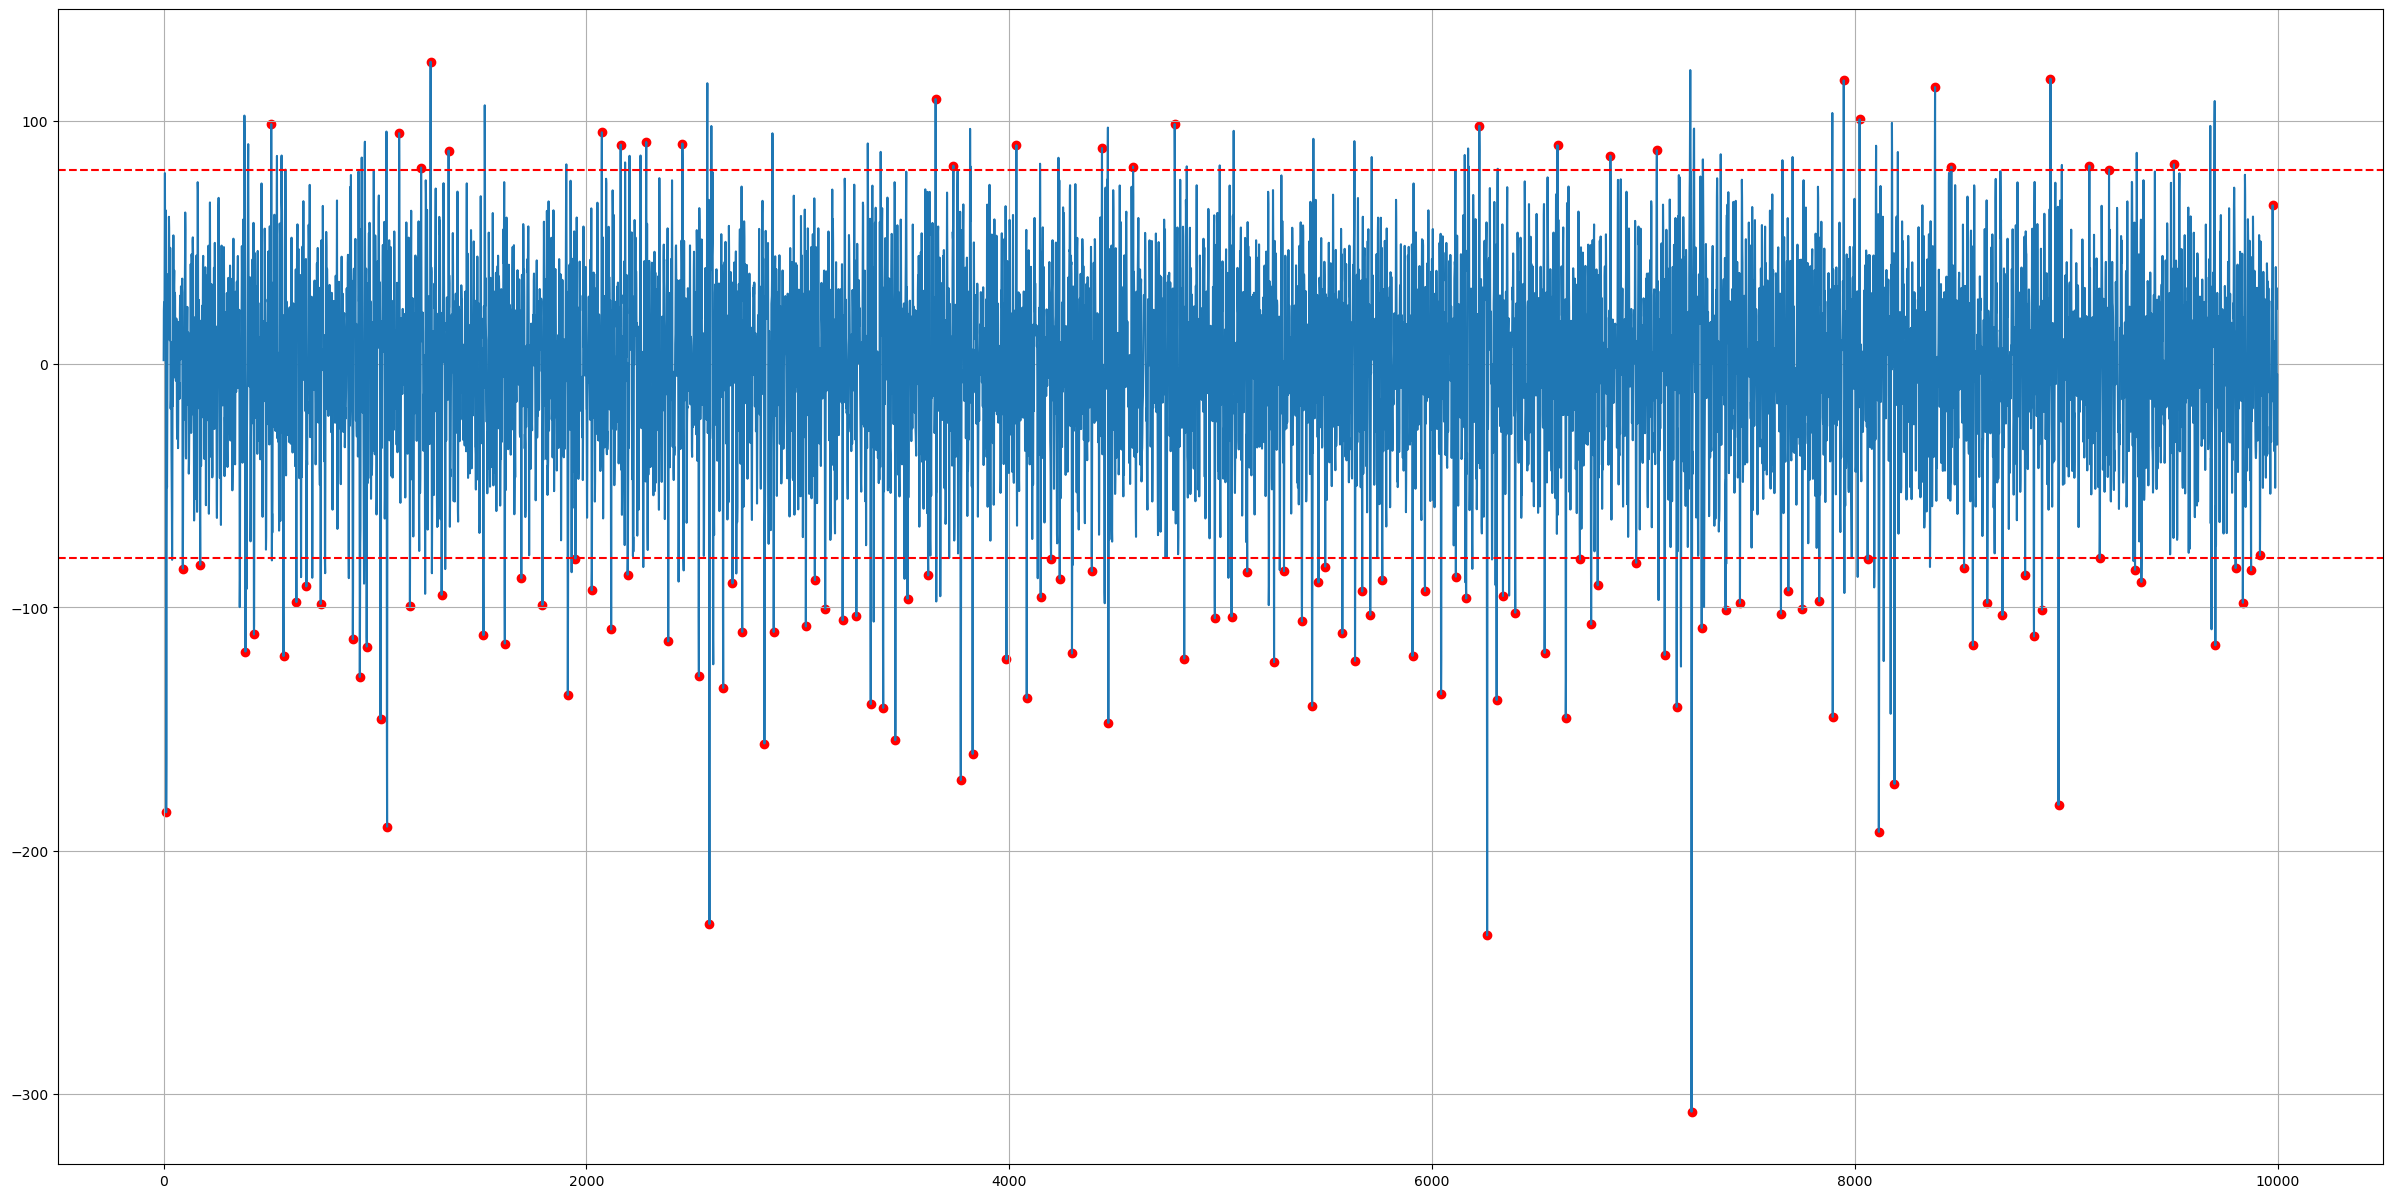

In [61]:
threshold=4*(scipy.stats.median_abs_deviation(abs_part,scale='normal'))
plt.figure(figsize=(30, 15))
plt.plot(part, label='Signal Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(inds1, [part[i] for i in inds1], c='red', marker='o', label='Local Maxima')
plt.grid(True)
#plt.axis([0,3000,-5,5])
plt.savefig('exampleofMADofABSO.jpg')
plt.show()

In [58]:
def this_windowed_spike_detection(data,abso):
    spike_length=30 #3ms
    window_length=10000 #1 sec
    abs_data=abs(data)
    i=0
    ind=[]
    while i < len(data)+window_length:
        abs_window=abs_data[i:i+window_length]
        window=data[i:i+window_length]
        if abso==0:
            coeff=4
            thresh=coeff*(scipy.stats.median_abs_deviation(window,scale='normal'))
        else:
            coeff=4
            thresh=coeff*(scipy.stats.median_abs_deviation(abs_window,scale='normal'))
        ind1, peaks =find_peaks(abs_window, height=thresh,distance=spike_length)
        last=i
        if len(ind1):
            last=i+ind1[-1]
        ind.extend([index + i for index in ind1])
        i=last+spike_length
    firing_rate=len(ind)*10000/len(data)
    print(len(ind), ' spikes detected;  ', 'firing rate: {:.2f}'.format(firing_rate),'Hz')
    return ind


In [ ]:
threshold=4*(scipy.stats.median_abs_deviation(prova,scale='normal'))
threshold

# Spike detection

In [ ]:
ind=find_all_spikes(prova,threshold)

In [89]:
def this_windowed_find_all_spikes(data,coeff):
    spike_length=30 #3ms
    window_length=10000 #1 sec
    abs_data=abs(data)
    i=0
    ind=[]
    while i < len(data)+window_length:
        abs_window=abs_data[i:i+window_length]
        window=data[i:i+window_length]
        thresh=coeff*(scipy.stats.median_abs_deviation(window,scale='normal'))
        ind1, peaks =find_peaks(abs_window, height=thresh,distance=spike_length)
        #print(ind1)
        last=i
        if len(ind1):
            last=i+ind1[-1]
        ind.extend([index + i for index in ind1])
        i=last+spike_length
    firing_rate=len(ind)*10000/len(data)
    print(len(ind), ' spikes detected;  ', 'firing rate: {:.2f}'.format(firing_rate),'Hz')
    return ind

In [90]:
ind=this_windowed_find_all_spikes(prova,4)

7580  spikes detected;   firing rate: 18.85 Hz


pos, neg, alls=find_all_spikes(prova,threshold)

BL:            
THRESH=4: fr 131 Hz (15014 pos, 40487 neg)           
THRESH=3: fr 390 Hz (72800 pos, 91948 neg)           
stim:     
THRESH=4: fr 14 Hz (2793 pos, 3261 neg)           
THRESH=3: fr 142.14 Hz (30101 pos, 30450 neg)       
24hrs:    
THRESH=4: fr 556 Hz (85496 pos, 149916 neg)            
THRESH=3: fr 1092.19 Hz (220928 pos, 240849 neg)

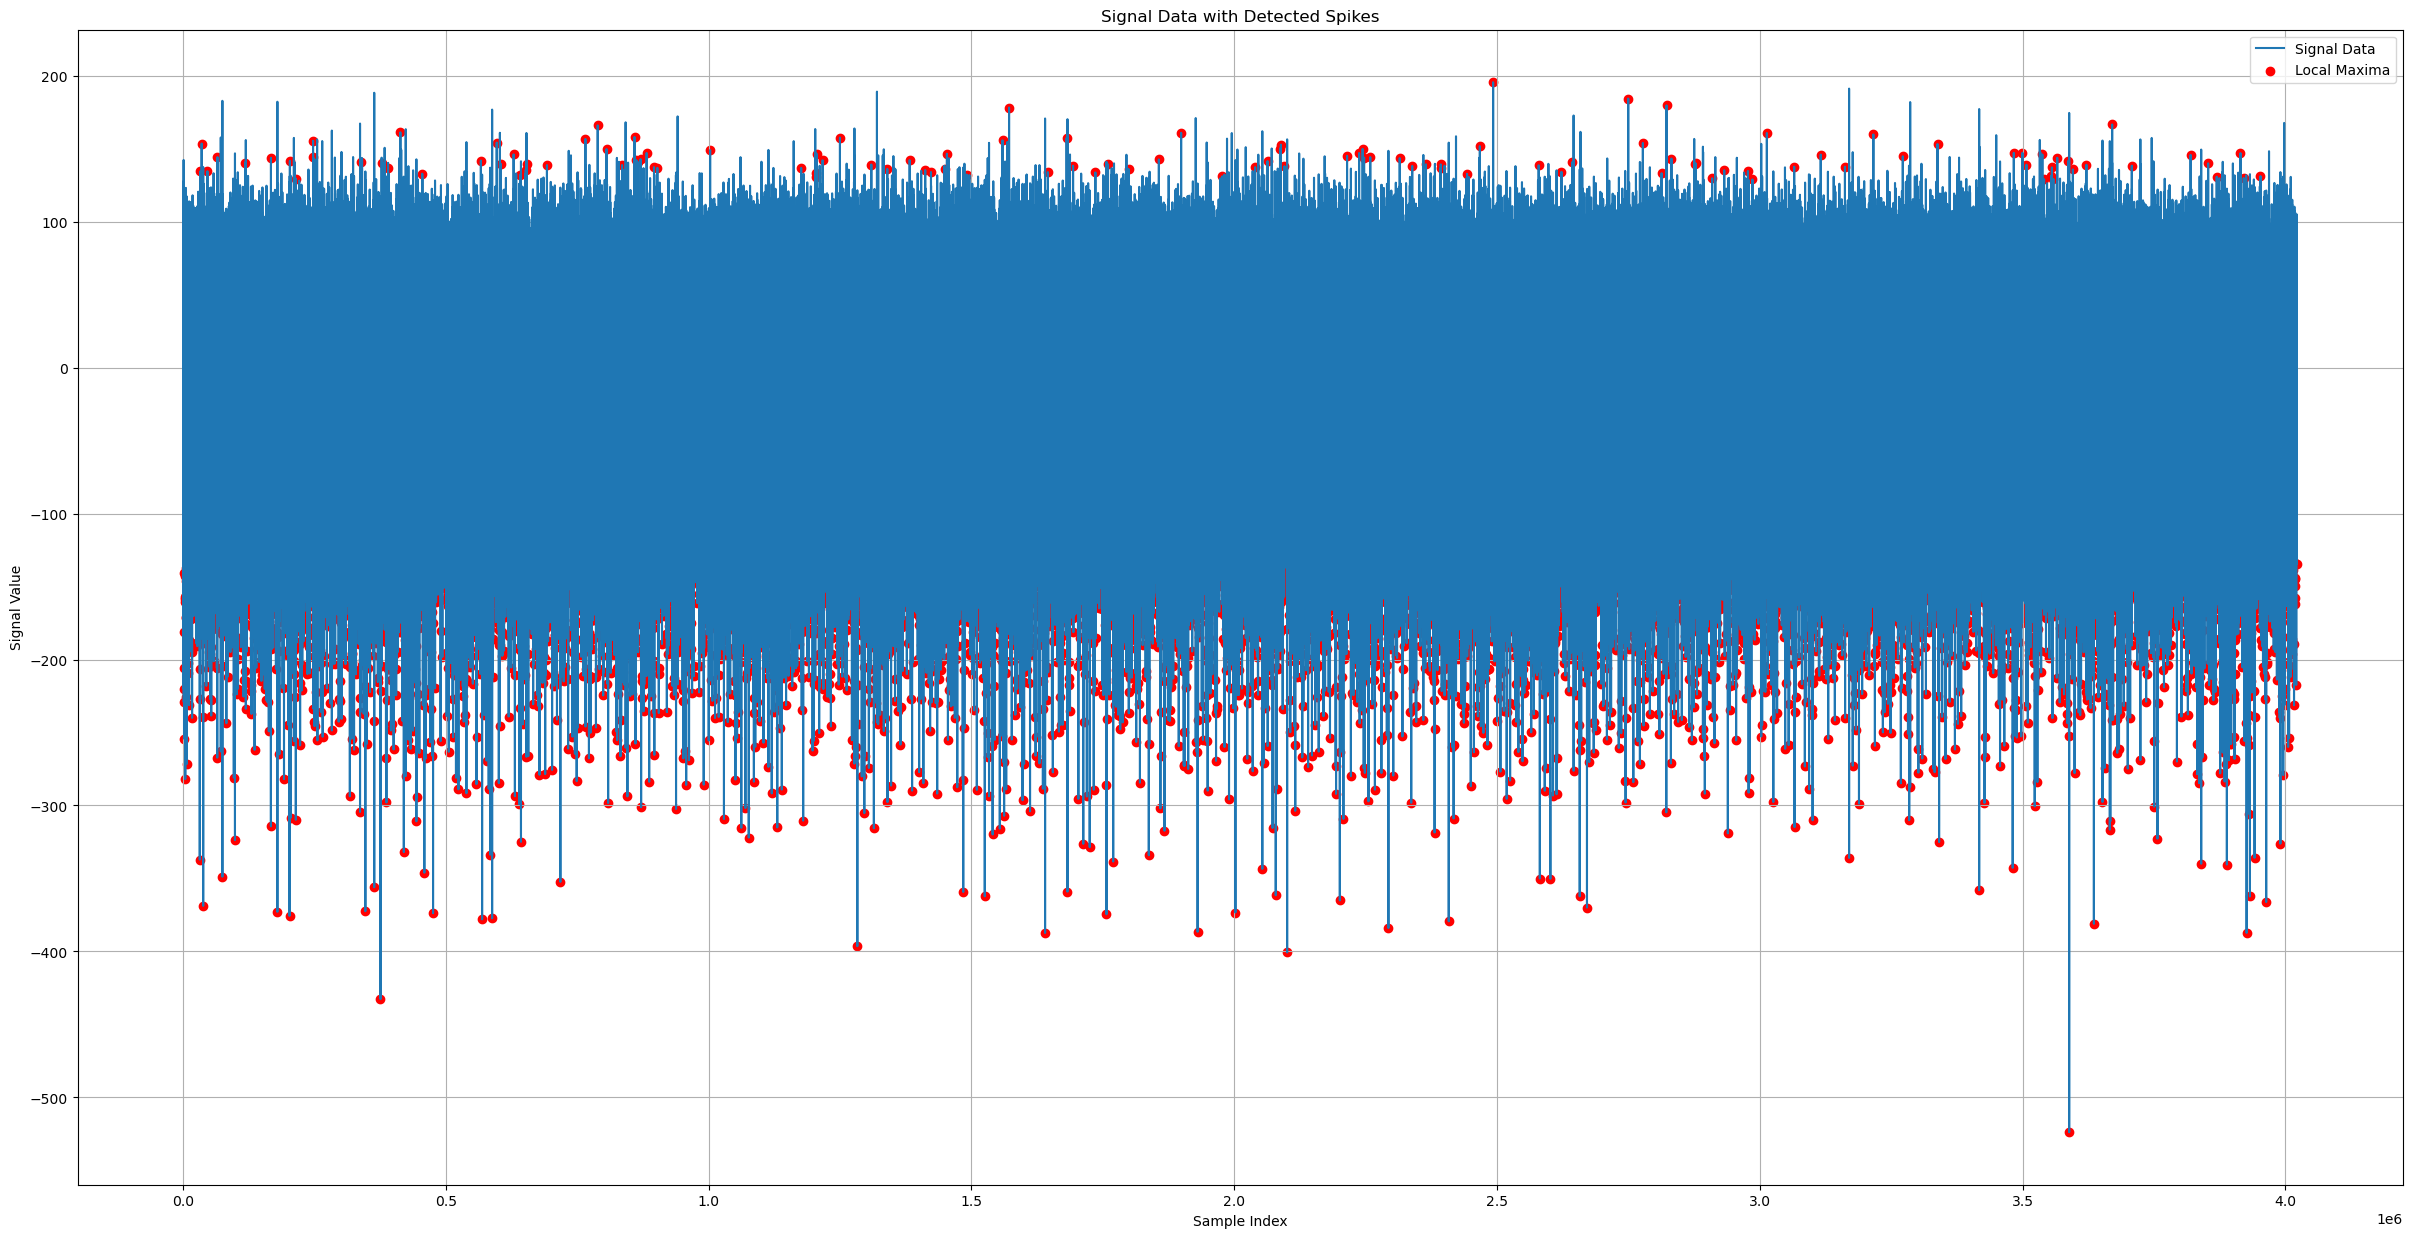

In [91]:
plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(ind, [prova[i] for i in ind], c='red', marker='o', label='Local Maxima')
#plt.scatter(neg, [prova[i] for i in neg], c='green', marker='o', label='Local Minima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,3000,-5,5])
#plt.savefig('spikes1.jpg')
plt.show()

# Cutouts

In [ ]:
c1=2
cut_outs,alls=cut_all(ind,prova,c1)

c1=1
pos_cut,n_pos, neg_cut,n_neg = cut(pos,neg,prova,c1)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

pos_cut=mask_cuts(pos_cut)
neg_cut= mask_cuts(neg_cut)

x=randint(1,min(len(pos_cut),len(neg_cut)))

plt.plot(savedp[x])
plt.plot(pos_cut[x])
plt.show()
#plt.plot(savedn[x])
#plt.plot(neg_cut[x])
#plt.show()

import pandas as pd
pca = PCA()
pca.fit(pos_cut)
explained_variances = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(data={'Explained Variance': explained_variances},
                                     index=range(1, len(explained_variances) + 1))
explained_variance_df.transpose()

cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_df = pd.DataFrame(data={'Cumulative Explained Variance': cumulative_explained_variance},
                                                index=range(1, len(cumulative_explained_variance) + 1))
cumulative_explained_variance_df.transpose()


# Clustering

In [ ]:
final_data=[]
final_data.append(selective_clus(cut,alls,prova))

In [ ]:
neurons=[]
for neuron in final_data:
    neurons.append(neuron[0])
len(neurons)

• distance tra indici detettati pari a lunghezza spike
• poi clustering con range dda 2 a 3 e se silhouette sotto una soglia è un cluster solo

In [ ]:
#x=randint(0,len(neurons)-1)
for x in range(0,len(neurons)):
    print('neur: ',x,len(neurons[x]))
    data_healthy=neurons[x]
    ISI_healthy = np.diff(data_healthy)/10000
    plt.hist(ISI_healthy, bins=100, density=False, alpha=0.5, color='blue', edgecolor='black')
    plt.show()

In [ ]:
adj_neur=[]
counter = 0
max_len=0

for neu in neurons:
    print('counter: ',counter,neu.shape[0])
    if neu.shape[0]>max_len:
        max_len=neu.shape[0]
    counter+=1
for neuron in neurons:
    if neuron.shape[0]<=max_len:
        diff = max_len-neuron.shape[0]
        adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))


x=randint(0,len(adj_neur)-1)
print('neur: ',x)
data_healthy=adj_neur[x]
ISI_healthy = np.diff(data_healthy)/10000

locs_diff=np.diff(data_healthy)
#plt.axis([-3,500,0,0.05])
plt.hist(locs_diff, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

## Point Process

In [ ]:
ISI_data=ISI_healthy

In [ ]:
map_estimate,ppc_trace= Bayesian_mixture_model(ISI_healthy)

In [ ]:
#with model:
#    ppc_trace = pm.sample_posterior_predictive(trace,model=model)
def trace(ppc_trace):
    bins = np.arange(0, .5, 1e-3) 
    plt.figure (figsize=(14,10))

    hist = np.histogram(ppc_trace['posterior_predictive']['like'].values,bins=bins)
    #plt.axis([-0.01,0.13,0,160])
    a= plt.hist(ISI_healthy,bins)
    plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3)
    plt.show()

In [ ]:
lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

In [ ]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / np.sum(counts)
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / np.sum(counts)

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

In [ ]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)
#plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [ ]:
def this_Bayesian_mixture_model(ISI_data):
    with pm.Model() as model:
        ##### WALD DISTRIBUTION (INVERSE GAUSSIAN)
        mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
        lam1 = pm.Uniform('lam1',lower=0.001,upper=0.04)
        obs1 = pm.Wald.dist(mu=mu1,lam=lam1)


        mu2 = pm.Uniform('mu2',lower=0,upper=0.2)
        sigma2 = pm.Uniform('sigma2',lower=0.0001,upper=0.5)
        obs2 = pm.TruncatedNormal.dist(mu=mu2, sigma=sigma2, lower=0.0)

        mu3 = pm.Uniform('mu3',lower=0.1,upper=0.6)
        sigma3 = pm.Uniform('sigma3',lower=0.0001,upper=0.5)
        obs3 = pm.TruncatedNormal.dist(mu=mu3, sigma=sigma3, lower=0.0)


        w = pm.Dirichlet('w', a=np.array([1., .4, .4]))
        #w = pm.Dirichlet('w', a=np.array([1., .4]))

        like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2, obs3], observed=ISI_data)
        #like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2], observed=ISI_data)

        step = pm.NUTS(target_accept=0.9)
        trace = pm.sample(step=step,draws=1000,chains=1,tune=1000,cores=4)
        
        ppc_trace = pm.sample_posterior_predictive(trace,model=model)
        if ppc_trace==0:
            print('ppc_trace not succesful')
        lista_samples=[]
        for i in list(ppc_trace['posterior_predictive']['like'].values):
            lista_samples.extend(i)
        counts, _ = np.histogram(ISI_healthy, bins) 
        prob_emp = counts / np.sum(counts)
        counts, _ = np.histogram(lista_samples, bins) 
        prob_model = counts / np.sum(counts)

        Femp = np.cumsum(prob_emp)           
        Fmodel = np.cumsum(prob_model)          
        plt.figure()
        plt.plot(bins[:-1], Femp)                
        plt.plot(bins[:-1], Fmodel, 'r')       
        #plt.xlim([0, 0.2])                  
        plt.xlabel('Time [s]')
        plt.ylabel('CDF')
        plt.legend(['Empirical','Model'])
        plt.show()
        plt.figure()
        Nlow = len(ISI_healthy)  
        # Plot the confidence bounds
        plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
        plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
        plt.plot(Femp, Fmodel)
        #plt.axis([0, 1, 0, 1])         
        plt.xlabel('Model CDF')
        plt.ylabel('Empirical CDF')
        plt.show()
        
    map_estimate = pm.find_MAP(model=model)
    
    del map_estimate['w_simplex__']
    del map_estimate['mu1_interval__']
    del map_estimate['lam1_interval__']
    del map_estimate['mu2_interval__']
    del map_estimate['sigma2_interval__']
    del map_estimate['mu3_interval__']
    del map_estimate['sigma3_interval__']
    
    map_estimate['w1'] = map_estimate['w'][0]
    map_estimate['w2'] = map_estimate['w'][1]
    map_estimate['w3'] = map_estimate['w'][2]

    del map_estimate['w']


    return map_estimate, ppc_trace

In [ ]:
dataframe = pd.DataFrame()
list_neurons = neurons
counter=0
target=0
print('Original number of neurons: ',len(list_neurons))
for neuron in list_neurons:
    neuron=neuron[neuron>0*10000]
    neuron=neuron[neuron<200*10000]
    print('  Neuron with ',neuron.shape[0],'spikes')
    if neuron.shape[0]>1000:

        counter+=1
    else:
        print('    Excluded neuron with n spikes = ',neuron.shape[0])
        continue

    ISI_healthy = np.diff(neuron)/10000


    map_estimate,ppc_trace = this_Bayesian_mixture_model(ISI_healthy)
    trace(ppc_trace)
    df = pd.DataFrame.from_dict(map_estimate,orient='index')
    dataframe = pd.concat([dataframe,df],axis = 1)
print('Final number of neurons: ',counter)
print('Target = ',target)

In [ ]:
final = dataframe.T
final.to_csv('Data after PP/DataAfter')

## Classification

In [ ]:
def performance_visualizer(trials_obj,n_models,choice=False,**choice_var):
    
    import pandas as pd
    
    performance = [1-t['result']['loss'] for t in trials_obj.trials]
    
    
    hyperparam= list(trials_obj.trials[0]['misc']['vals'].keys())
    
    values_dict ={}
    
    for i in hyperparam:
        
        values_dict[i]=[]
        
        for j in trials_obj.trials:
            
            if(len(j['misc']['vals'][i])==0):
                
                values_dict[i].append(np.NaN)
                
            else:
            
                values_dict[i].append(j['misc']['vals'][i][0])
                
    out = pd.DataFrame.from_dict(values_dict)
    
    out['performance'] = performance
    
    out=out.sort_values(by=['performance'])
    
    
    if choice:
        
        for i in list(choice_var.keys()):
        
            for j,_ in enumerate(choice_var[i]):
        
                out[i]=out[i].replace(j,choice_var[i][j])
    
    return out.tail(n_models)

In [ ]:
dataset = pd.read_csv('Data after PP/Data')
dataset = dataset.drop(['Unnamed: 0'],axis=1)
dataset